<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats1/blob/main/normalgamma_Rosenthal_and_Jacobson_1968.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rosenthal and Jacobson (1968) の実験の結果を分析

* データは、原論文のものではなく、それに似せて作ったもの。
 * [STA 360/602: Bayesian Methods and Modern Statistics @ Duke University](http://www2.stat.duke.edu/~rcs46/bayes17.html)の[Module 4](http://www2.stat.duke.edu/~rcs46/modern_bayes17/lecturesModernBayes17/lecture-4/04-normal-gamma.pdf)より拝借したデータ。


> Do a teacher’s expectations influence student achievement? In a
famous study, Rosenthal and Jacobson (1968) performed an
experiment in a California elementary school to try to answer this
question. At the beginning of the year, all students were given an
IQ test. For each class, the researchers randomly selected around
20% of the students, and told the teacher that these students were
“spurters” that could be expected to perform particularly well that
year. (This was not based on the test—the spurters were randomly
chosen.) At the end of the year, all students were given another IQ
test.



## 問題設定
* 教師が期待をかけるか否かで学生の学修に影響があるかを知りたい。
* このことを、$P(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を調べることで、明らかにする。
 * $\mathbf{x}_s$: spurters（期待をかけられた学生たち）のIQ変化量データ群
 * $\mathbf{x}_c$: controls（その他の学生たち）のIQ変化量データ群
 * $\mu_s$: spurtersのIQ変化量の平均値
 * $\mu_c$: controlsのIQ変化量の平均値

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%config InlineBackend.figure_format = 'retina'

## モデリングの方針
* IQスコア変化量は、正規分布に従うと仮定する。
* spurtersとcontrolsそれぞれに、別々の事前分布を導入する。
* 事前分布としては、正規ガンマ分布を用いる。

## データ
* spurtersとcontrolsのIQスコアの変化量

In [172]:
x_s = [18, 40, 15, 17, 20, 44, 38]
x_c = [-4, 0, -19, 24, 19, 10, 5, 10,
       29, 13, -9, -8, 20, -1, 12, 21,
       -7, 14, 13, 20, 11, 16, 15, 27,
       23, 36, -33, 34, 13, 11, -19, 21,
       6, 25, 30,22, -28, 15, 26, -1, -2,
       43, 23, 22, 25, 16, 10, 29]

In [173]:
x_s = np.array(x_s)
x_c = np.array(x_c)
N_s = len(x_s)
N_c = len(x_c)

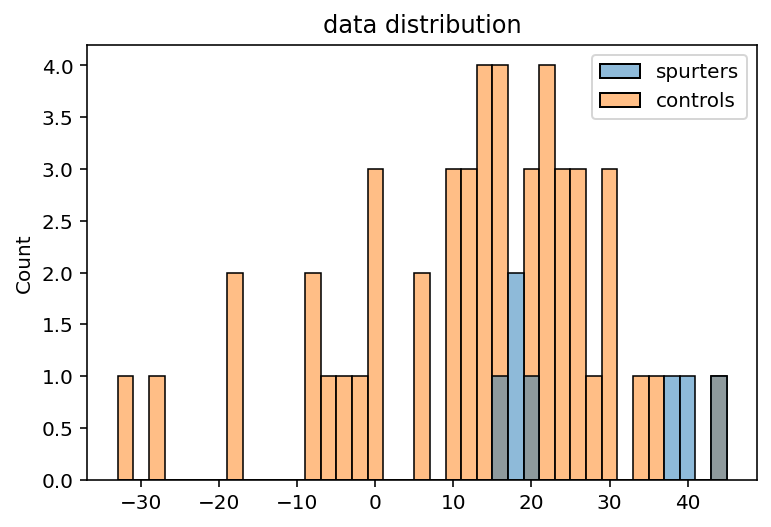

In [174]:
ax = sns.histplot({'spurters':x_s, 'controls':x_c}, binwidth=2)
ax.set_title('data distribution');

## 事前分布のパラメータの設定

* $\alpha$は、事前分布がデータ1個分の情報を持つように設定されている。
 * 事後分布のshapeパラメータが$\alpha + N / 2$となるため。
* $\beta$は、IQスコアの変化量の標準偏差$\sqrt{\beta / \alpha}$が10ぐらいになるように設定されている。
 * ガンマ分布$\mbox{Gamma}(\alpha, \beta)$に従う確率変数の値の平均は$\alpha / \beta$。
 * ガンマ分布は、ここでは、IQスコアの変化量が従う正規分布の精度（＝分散の逆数）が従う分布として使われている。

In [175]:
alpha = 0.5
beta = 100 * alpha

* $\lambda_0$は、どう設定していいか分からないので$1$にする。
* $\mu_0$は、spurtersとcontrolsを合わせたデータ全体の平均値に設定する。

In [176]:
lambda_0 = 1.0
mu_0 = (x_s.sum() + x_c.sum()) / (N_s + N_c)
print(mu_0)

14.0


## 事後分布のパラメータの計算
* データ集合が与えられれば、この計算は実行できる。

In [177]:
mu_s = (lambda_0 * mu_0 + sum(x_s)) / (lambda_0 + N_s)
mu_c = (lambda_0 * mu_0 + sum(x_c)) / (lambda_0 + N_c)
lambda_s = lambda_0 + N_s
lambda_c = lambda_0 + N_c
alpha_s = alpha + N_s / 2
alpha_c = alpha + N_c / 2
beta_s = beta + (((x_s - x_s.mean()) ** 2).sum() + lambda_0 * N_s * (x_s.mean() - mu_0) ** 2 / (lambda_0 + N_s)) / 2
beta_c = beta + (((x_c - x_c.mean()) ** 2).sum() + lambda_0 * N_c * (x_c.mean() - mu_0) ** 2 / (lambda_0 + N_c)) / 2

## 事後分布からサンプリング
* 正規ガンマ分布$\mu, \tau \sim \mbox{NormalGamma}(\mu_0, \lambda_0, \alpha, \beta)$からサンプリングするには・・・
* まず、ガンマ分布$\tau \sim \mbox{Gamma}(\alpha, \beta)$から$\tau$をサンプリングし、
* 次に、正規分布$\mu \sim \mathcal{N}(\mu_0, 1 / (\lambda_0\tau))$から$\mu$をサンプリングすればよい。

In [178]:
from scipy.stats import gamma

In [179]:
rv_s = gamma(alpha_s, scale=1/beta_s)
rv_c = gamma(alpha_c, scale=1/beta_c)

In [180]:
n_samples = 1000

tau_s_samples = rv_s.rvs(n_samples)
mean_s_samples = np.random.randn(n_samples) / np.sqrt(lambda_s * tau_s_samples) + mu_s
tau_c_samples = rv_c.rvs(n_samples)
mean_c_samples = np.random.randn(n_samples) / np.sqrt(lambda_c * tau_c_samples) + mu_c

* 平均パラメータの分布のヒストグラムを描く
 * このヒストグラムが、平均パラメータが従う事後分布を近似しているはず。

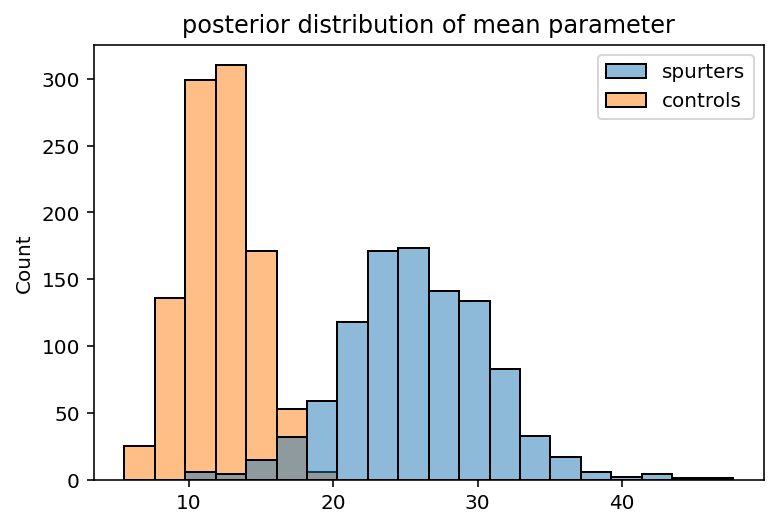

In [181]:
ax = sns.histplot({'spurters':mean_s_samples, 'controls':mean_c_samples})
ax.set_title('posterior distribution of mean parameter');

* 標準偏差パラメータの分布のヒストグラムを描く

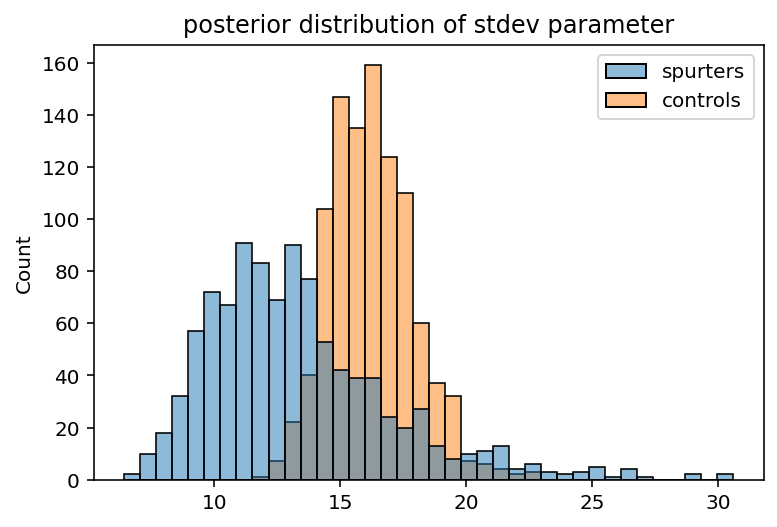

In [182]:
sigma_s_samples = np.sqrt(1 / tau_s_samples)
sigma_c_samples = np.sqrt(1 / tau_c_samples)
ax = sns.histplot({'spurters':sigma_s_samples, 'controls':sigma_c_samples})
ax.set_title('posterior distribution of stdev parameter');

## $\mu_s > \mu_c$となる確率の計算

In [183]:
(mu_s_samples > mu_c_samples).sum() / n_samples

0.997

## 予測分布を求める
* t分布について、自由度とlocationとscaleを、 指定する。

In [184]:
from scipy.stats import t

In [185]:
n_samples = 10000

rv_s = t(2 * alpha_s, loc=mu_s, scale=np.sqrt(beta_s * (lambda_s + 1) / (alpha_s * lambda_s)))
x_s_samples = rv_s.rvs(n_samples)
rv_c = t(2 * alpha_c, loc=mu_c, scale=np.sqrt(beta_c * (lambda_c + 1) / (alpha_c * lambda_c)))
x_c_samples = rv_c.rvs(n_samples)

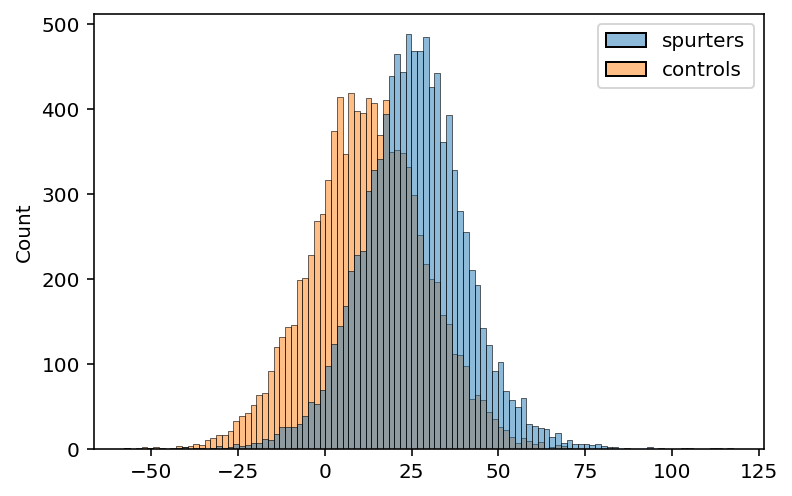

In [186]:
sns.histplot({'spurters':x_s_samples, 'controls':x_c_samples});

* 同じ条件下で、次に観測されるspurterのIQ変化量が、次に観測されるcontrolのIQ変化量よりも大きい確率

In [187]:
(x_s_samples > x_c_samples).sum() / n_samples

0.7348